In [2]:

import numpy as np 
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path+"/openmd")

from SimulatorLJ import SimulatorLJ as Simulator

def initialize(num_part, sigma, length):
    """
    :param num_part:
    :type num_part:
    :return:
    :rtype:
    """
    coordinates = np.zeros((num_part, 3))
    pos_x = (0, length, 2**(1/6)*sigma)
    i = 0
    for x in pos_x:
        for y in pos_x:
            for z in pos_x:
                coordinates[i, :] = np.array([x , y ,z])
                i += 1
                if i == num_part-1:
                    break
            if i == num_part - 1:
                break
        if i == num_part - 1:
            break
    return coordinates

coordinates = initialize(2, 1, 6)
velocities = np.array([[1,0,0],[-1,0,0]])
sim = Simulator(
    path = r"C:/Users/ZhenAK97/Desktop" ,
    title = 'test_2',
    mass = 1,
    sim_time= 100,
    time_step = 1,
    initial_values = [coordinates,velocities],
    box_length = 6 ,
    force=None,
    force_constants=[1, 1],
    integrator=None
)
positions, velocities = sim.simulate()

c:\Users\ZhenAK97\Documents\GitHub\openmd


TypeError: bad operand type for unary -: 'list'

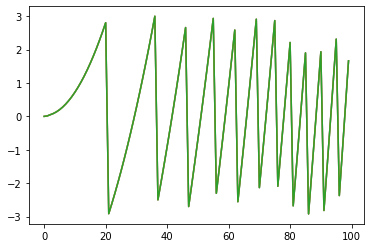

In [2]:
import matplotlib.pyplot as plt 
plt.plot(positions[0,:,:].T)

In [12]:
import h5py

filename = r'C:/Users/ZhenAK97/Desktop/test_1.hdf5'

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    position_data = list(f[a_group_key])
    position_data = np.array(position_data)
    
    
    velocity_data = list(f[list(f.keys())[1]])
    velocity_data = np.array(velocity_data)
    
    print(position_data.shape)
    print(velocity_data.shape)

Keys: <KeysViewHDF5 ['positions', 'velocity']>
(64, 3, 100)
(64, 3, 100)


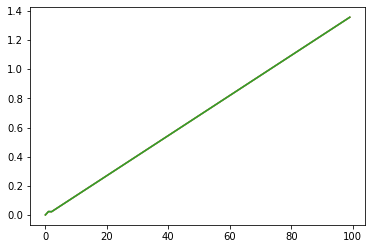

In [3]:
plt.plot(velocities[0,:,:].T)